## Imports

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tqdm.notebook import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [88]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [89]:
df = pd.read_csv('/content/gdrive/MyDrive/ML Project/Womens Clothing E-Commerce Reviews.csv')

## Data Preprocessing

In [90]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

Drop Some Features

In [91]:
df = df.drop(['Unnamed: 0', 'Clothing ID', 'Positive Feedback Count', 'Division Name'], axis=1)

Combine Recommended IND, Age, Department, Class, Title and Review

In [92]:
df['Combined Text'] = df.apply(lambda row: "{0} My age is {1} years.{2}{3}{4}{5}".format(
    "I recommend this item." if row['Recommended IND'] == 1 else "I don't recommend this item.",
    row["Age"],
    f" This item is from the {row['Department Name']} department." if not pd.isna(row['Department Name']) else "",
    f" It falls under the {row['Class Name']} class." if not pd.isna(row['Class Name']) else "",
    f" {row['Title']}." if not pd.isna(row['Title']) else "",
    f" {row['Review Text']}" if not pd.isna(row['Review Text']) else "",
), axis=1)

Lowercase

In [93]:
df['Combined Text'] = df['Combined Text'].str.lower()

In [94]:
df.shape

(23486, 8)

In [95]:
df['Recommended IND'].value_counts(normalize=True)

1    0.822362
0    0.177638
Name: Recommended IND, dtype: float64

Train-Validation-Test Split

In [96]:
X = df['Combined Text'].values
y = pd.get_dummies(df['Rating']).values

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
  )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape

((16440,), (3523,), (3523,))

## Training Parameters (for all models)

Training Parameters (Recommended in BERT Paper published by Google):
* Optimizer: Adam
* Learning Rate: 2e-5
* Epochs: 10
* Batch Size: 32
* Early Stopping (Validation Loss with Patience = 3)

In [97]:
optimizer = Adam(learning_rate=2e-5)

## BERT Base

In [98]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Find Max Token Length

In [99]:
token_length_bert_base = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length_bert_base = max(token_length_bert_base)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [100]:
X_test_tokens_bert_base = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length_bert_base,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [101]:
def create_model_bert_base():
    input_ids = Input(shape=(max_token_length_bert_base,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length_bert_base,), dtype=tf.int32)

    bert_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
    outputs = bert_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(5, activation='softmax')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

In [102]:
model_bert_base = create_model_bert_base()
model_bert_base.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_bert_base.load_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Base (Rating).h5')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## BERT Dense

In [103]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Find Max Token Length

In [104]:
token_length_bert_dense = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length_bert_dense = max(token_length_bert_dense)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [105]:
X_test_tokens_bert_dense = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length_bert_dense,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [106]:
def create_model_bert_dense():
    input_ids = Input(shape=(max_token_length_bert_dense,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length_bert_dense,), dtype=tf.int32)

    bert_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
    outputs = bert_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    dense_layer_1 = Dense(512, activation='relu')(pooled_output)
    dropout_layer_1 = Dropout(0.1)(dense_layer_1)

    dense_layer_2 = Dense(256, activation='relu')(dropout_layer_1)
    dropout_layer_2 = Dropout(0.1)(dense_layer_2)

    dense_layer_3 = Dense(128, activation='relu')(dropout_layer_2)
    dropout_layer_3 = Dropout(0.1)(dense_layer_3)

    output_layer = Dense(5, activation='softmax')(dropout_layer_3)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

In [107]:
model_bert_dense = create_model_bert_dense()
model_bert_dense.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_bert_dense.load_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Dense (Rating).h5')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## DistilBERT Model

In [108]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Find Max Token Length

In [109]:
token_length_distilbert = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length_distilbert = max(token_length_distilbert)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [110]:
X_test_tokens_distilbert = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length_distilbert,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [111]:
def create_model_distilbert():
    input_ids = Input(shape=(max_token_length_distilbert,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length_distilbert,), dtype=tf.int32)

    distilbert_model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
    outputs = distilbert_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(5, activation='softmax')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

In [112]:
model_distilbert = create_model_distilbert()
model_distilbert.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_distilbert.load_weights('/content/gdrive/MyDrive/ML Project/Weights/DistilBERT (Rating).h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## AlBERT Model

In [113]:
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

Find Max Token Length

In [114]:
token_length_albert = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length_albert = max(token_length_albert)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [115]:
X_test_tokens_albert = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length_albert,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [116]:
def create_model_albert():
    input_ids = Input(shape=(max_token_length_albert,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length_albert,), dtype=tf.int32)

    albert_model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2')
    outputs = albert_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(5, activation='softmax')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

In [117]:
model_albert = create_model_albert()
model_albert.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_albert.load_weights('/content/gdrive/MyDrive/ML Project/Weights/ALBERT (Rating).h5')

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## RoBERTa

In [118]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

Find Max Token Length

In [119]:
token_length_roberta = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length_roberta = max(token_length_roberta)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [120]:
X_test_tokens_roberta = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length_roberta,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [121]:
def create_model_roberta():
    input_ids = Input(shape=(max_token_length_roberta,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length_roberta,), dtype=tf.int32)

    roberta_model = TFAutoModelForSequenceClassification.from_pretrained('roberta-base')
    outputs = roberta_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(5, activation='softmax')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

In [122]:
model_roberta = create_model_roberta()
model_roberta.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_roberta.load_weights('/content/gdrive/MyDrive/ML Project/Weights/RoBERTa (Rating).h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

## Model Predictions

In [123]:
y_pred_bert_base = model_bert_base.predict([X_test_tokens_bert_base['input_ids'], X_test_tokens_bert_base['attention_mask']])
y_pred_bert_dense = model_bert_dense.predict([X_test_tokens_bert_dense['input_ids'], X_test_tokens_bert_dense['attention_mask']])
y_pred_distilbert = model_distilbert.predict([X_test_tokens_distilbert['input_ids'], X_test_tokens_distilbert['attention_mask']])
y_pred_albert = model_albert.predict([X_test_tokens_albert['input_ids'], X_test_tokens_albert['attention_mask']])
y_pred_roberta = model_roberta.predict([X_test_tokens_roberta['input_ids'], X_test_tokens_roberta['attention_mask']])

111/111 [==============================] - 48s 411ms/step


In [124]:
y_test = np.argmax(y_test, axis=1) + 1
y_pred_class_bert_base = np.argmax(y_pred_bert_base, axis=1) + 1
y_pred_class_bert_dense = np.argmax(y_pred_bert_dense, axis=1) + 1
y_pred_class_distilbert = np.argmax(y_pred_distilbert, axis=1) + 1
y_pred_class_albert = np.argmax(y_pred_albert, axis=1) + 1
y_pred_class_roberta = np.argmax(y_pred_roberta, axis=1) + 1

In [125]:
ensemble_predictions = np.round(np.mean([y_pred_class_bert_base, y_pred_class_bert_dense, y_pred_class_distilbert, y_pred_class_albert, y_pred_class_roberta], axis=0)).astype(int)

In [126]:
accuracy_score(y_test, ensemble_predictions)

0.7144479137099063

In [127]:
precision_score(y_test, ensemble_predictions, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6931068081277597

In [128]:
recall_score(y_test, ensemble_predictions, average='weighted')

0.7144479137099063

In [129]:
f1_score(y_test, ensemble_predictions, average='weighted')

0.7021867284139804

In [130]:
print(classification_report(y_test, ensemble_predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       126
           2       0.39      0.57      0.46       235
           3       0.53      0.46      0.50       431
           4       0.56      0.56      0.56       761
           5       0.86      0.89      0.88      1970

    accuracy                           0.71      3523
   macro avg       0.47      0.50      0.48      3523
weighted avg       0.69      0.71      0.70      3523



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


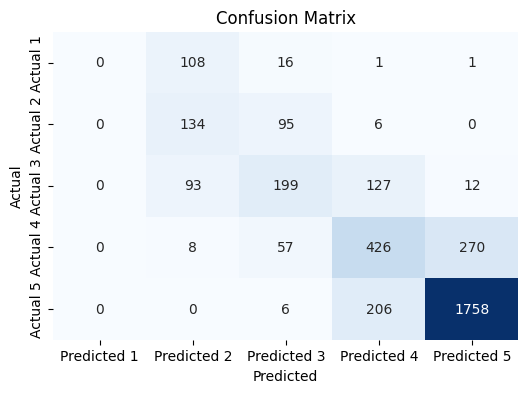

In [131]:
cm = confusion_matrix(y_test, ensemble_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()